In [2]:
import sys
sys.path.append('./')
import DataGen
import technical_indicators as ti
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from strategy_test import strategy_test
import json
import joblib
import utils
import ml_model as ml
import warnings

This notebook analyzes the performance of traditional technique indicators based strategies. These kind of strategies usually use hard coded rules to determine when to buy and sell the aseet. For example, one can use momentum index RSI as buying and selling signals. When it is above 70, one will buy in and sell it when it is below 30. <br>
This note book explores the validility of these strategies. What's more, I provide the search for the optimal thresholds for investment decisions based on historical performances other than the hardcoded one. <br>
For examples, for RSI, the best cut-off value for buying maybe 80 rather than 70. We can search all the values possible and pick the one that generates high, stable returns.<br>
However, throughout the study I personally conducted, it is dissapointing so far. That one can't use one single threshold to decide when to buy or sell. Most of cases, these decisions under-perform the baseline strategy, which is entering into the long position all the time on the coin.<br>

In [3]:
dg=DataGen.DataGen('Gemini','BTC','D')
dg.load()

windowsizes=[int(x) for x in np.linspace(1,90,90)]
responses=dg.get_leading_log_rt(windowsizes)
responses.dropna(inplace=True)

data=dg.get_data()

tid=ti.technical_indicators(data)
technical_index=tid.default_idts()

We can performe some simple anslysis on the technical index as below to see if it is stationary and normally distributed. This is helpful to transform the indicators later. The autocorrelation and partial correlation plots will be useful for those strategies combinning signals from different time-window. For example, the moving average strategy often compares the long term average with short term average to decide when to buy in and sell.

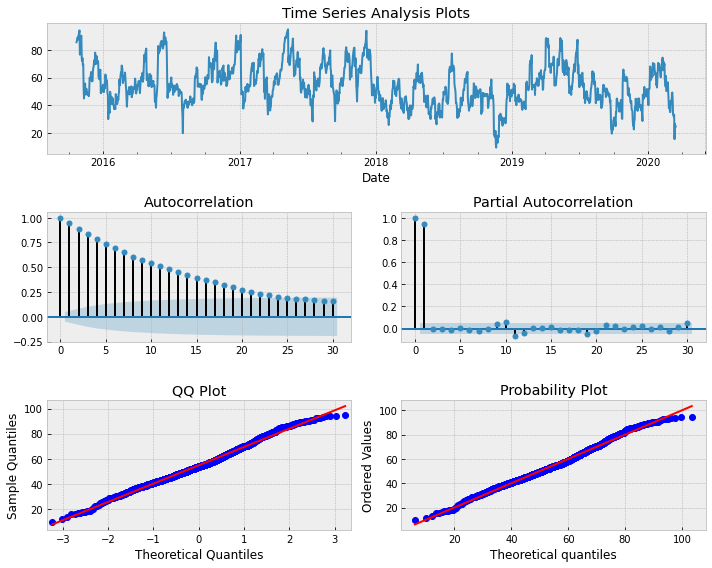

In [8]:
warnings.filterwarnings('ignore')
target='RSI'

fig=utils.tsplot(technical_index[target].dropna(), lags=30)
fig.savefig('./test/TSA_'+target+'.png')

In [5]:
tech=technical_index[[target]]
tech.dropna(inplace=True)

start=max(tech.index.min(),responses.index.min())
end=min(tech.index.max(),responses.index.max())

Now we can test the performance of the specific technique index by run it with different thresholds and calculates the precision and average return. Use RSI as an example, test it on 7-day investment horizons from 2015-2020.

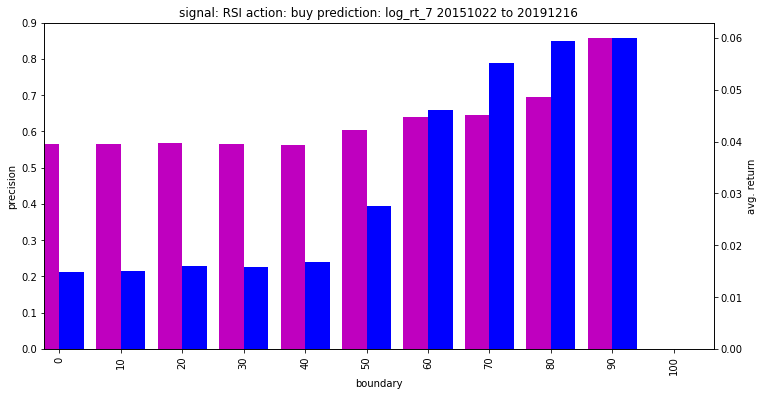

In [6]:
rules={'action':'buy','y':'log_rt_7','signal':'RSI'}
test=strategy_test(rules,tech,responses)
test.signal_testing(start,end,[10*i for i in range(11)])

As we can see, RSI is a good indicators to buy. The higher it is, the better the precision and the higher the avarage return. The left most bar is the benchmark performance. As RSI become greater than 50, it significantly beats the benchmark in terms of avg. return with slightly improved precision. One can use 70 as the cut-off point to enter into long positions. Or we can use higher values to have higher precisions and avg. return. It is noted that the precision (shown by the magenta bars) is only sligtly better than the benchmark. It is only when RSI greater than 80 that it rise to 0.7.

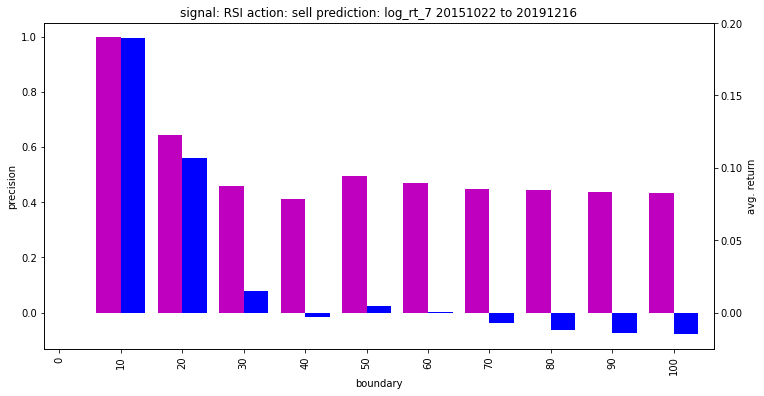

In [7]:
rules={'action':'sell','y':'log_rt_7','signal':'RSI'}
test=strategy_test(rules,tech,responses)
test.signal_testing(start,end,[10*i for i in range(11)])

We can also test the RSI to decide whether it is good strategy to sell. The return is calulated as the short position return. It has to be positive to show that it is valid for indicating sell. The right most bar is the benchmark strategy which is always holding short position. When RSI falls below 30, it began to outperform the benchmark yet the precision is less than 0.5. The lower it is, the more precise it is. One has to pick 20 if we want the precision above 0.5.

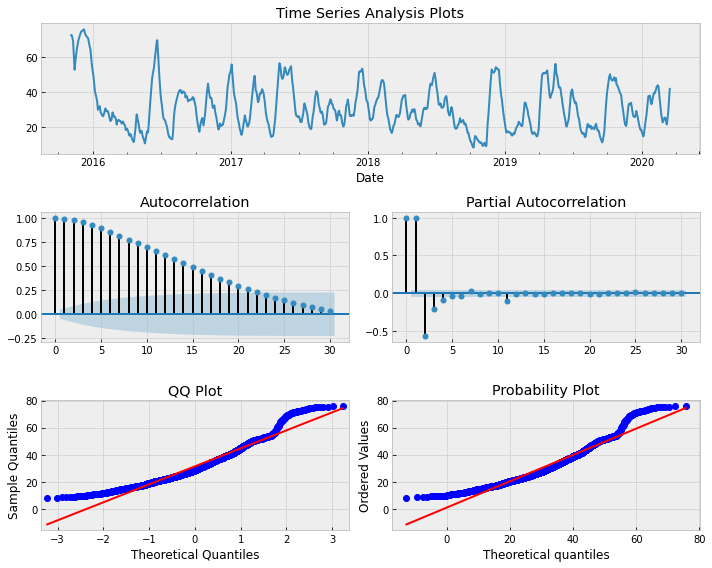

In [9]:
target='ADX'
fig=utils.tsplot(technical_index[target].dropna(), lags=30)
fig.savefig('./test/TSA_'+target+'.png')

In [ ]:
tech=technical_index[[target]]
tech.dropna(inplace=True)

start=max(tech.index.min(),responses.index.min())
end=min(tech.index.max(),responses.index.max())

Next, we take a look at another technique single 'ADX'. It is believed when it is above 25, one should buy. And when it is below 20, one should sell. We are going to test the ideas on BTC. Use 7 dyas as the investment window.

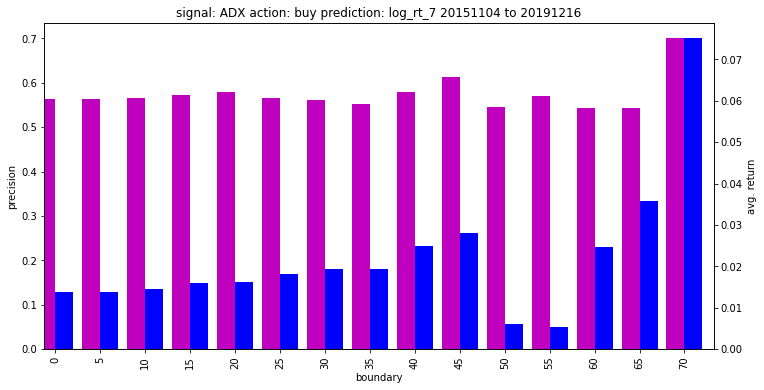

In [11]:
rules={'action':'buy','y':'log_rt_7','signal':'ADX'}
test=strategy_test(rules,tech,responses)
test.signal_testing(start,end,[5*i for i in range(15)])

The cut off 25 is slightly better than benchmark yet not significant. It is better to pick 45 as the buy in threshold. The overall precision is low, less than 0.6 mostly.

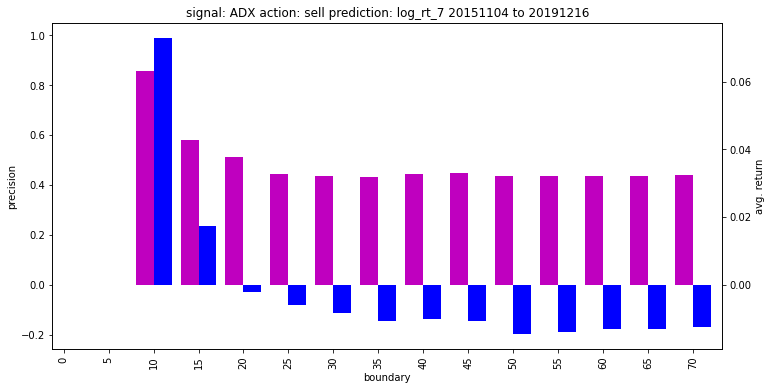

In [12]:
rules={'action':'sell','y':'log_rt_7','signal':'ADX'}
test=strategy_test(rules,tech,responses)
test.signal_testing(start,end,[5*i for i in range(15)])

Nor does it serve as a good indicator to sell. The cut-off level 20 doesn't work well with negative returns and low precision. One can use 15 or 10 instead.